In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings

warnings.filterwarnings('ignore')

In [2]:
# Загрузим предложенный файл
df = pd.read_csv('data_for_test.csv')

In [3]:
# Посмотрим на структуру данных, смотрим через head, 
# т.к. не знаем его размер, может уйти много времени при большом df на отображение
# Видим наличие дубликатов и сразу удалим их, чтобы не обрабатывать ненужные данные
df.head()

,time_start_local,time_end_local,time_offset,steps
0,2022-03-19 01:21:58,2022-03-19 01:22:00,3600,2
1,2022-03-19 01:21:58,2022-03-19 01:22:00,3600,2
2,2022-03-19 04:52:50,2022-03-19 04:52:55,3600,6
3,2022-03-19 04:52:55,2022-03-19 04:52:50,3600,6
4,2022-03-19 04:52:55,2022-03-19 04:52:50,3600,6


In [4]:
df.drop_duplicates(inplace=True)

In [5]:
# Смотрим типы данных, количество пропущенных значений
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7827 entries, 0 to 9825
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   time_start_local  7827 non-null   object
 1   time_end_local    7827 non-null   object
 2   time_offset       7827 non-null   int64 
 3   steps             7827 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 305.7+ KB


In [6]:
# Статистика по df, видим что offset изменется, хотя при первом отображении казалось, что везде одинаковое знанчение
# Также виден размах в количестве шагов
df.describe()

,time_offset,steps
count,7827.000000,7827.000000
mean,6439.248754,42.501980
std,1469.774821,100.806522
min,3600.000000,0.000000
25%,7200.000000,6.000000
50%,7200.000000,11.000000
75%,7200.000000,46.000000
max,7200.000000,2255.000000


In [7]:
# Распределение по offset
df['time_offset'].value_counts()

7200    6173
3600    1654
Name: time_offset, dtype: int64

In [8]:
# Преобразуем тип столбцов в даты
df[['time_start_local', 'time_end_local']] = df[['time_start_local', 'time_end_local']].apply(pd.to_datetime)

In [9]:
df.dtypes

time_start_local    datetime64[ns]
time_end_local      datetime64[ns]
time_offset                  int64
steps                        int64
dtype: object

In [10]:
# Приведем все даты к одинаковому формату UTC и удалим больше ненужную колонку offset
df['time_start_local']=df['time_start_local']-df['time_offset'].apply(lambda x: datetime.timedelta(seconds=x))
df['time_end_local']=df['time_end_local']-df['time_offset'].apply(lambda x: datetime.timedelta(seconds=x))
df=df.drop(columns = ['time_offset'],axis = 1)

In [11]:
# Найдем длину интервала между началом и концом промежутка
df['segment'] = df['time_end_local']-df['time_start_local']

In [12]:
# Посмотрим результат, видно что есть отрицательные, скорее всего это ошибка записи/прибора, 
# т.к. они инвертированно дублируют предыдущую верную строку (если говорить о строках 2 и 3)
df.head()

,time_start_local,time_end_local,steps,segment
0,2022-03-19 00:21:58,2022-03-19 00:22:00,2,0 days 00:00:02
2,2022-03-19 03:52:50,2022-03-19 03:52:55,6,0 days 00:00:05
3,2022-03-19 03:52:55,2022-03-19 03:52:50,6,-1 days +23:59:55
5,2022-03-19 06:55:35,2022-03-19 06:55:40,6,0 days 00:00:05
6,2022-03-19 07:15:33,2022-03-19 07:25:34,143,0 days 00:10:01


In [13]:
# Посмотрим процент отрицательных записей от общего числа записей, всего 6,4 процента
# Тогда пока будем считать их ошибочными и удалим из общего набора данных, это небольшая потеря
print(f'Процент отрицательных записей от общего набора данных составляет \
{round(df[df.segment<datetime.timedelta(seconds=0)].shape[0]*100/df.shape[0],2)} %')

Процент отрицательных записей от общего набора данных составляет 6.39 %


In [14]:
# Переводим временной промежуток в минуты, убирая из столбца отрицательные значения
df['segment_min']=df[df.segment>datetime.timedelta(seconds=0)]['segment'].dt.seconds/60
df.drop(columns=['segment'], axis=1, inplace=True)

In [15]:
# Остались NaN в отрицательных промежутках, удалим эти строки
df.head()

,time_start_local,time_end_local,steps,segment_min
0,2022-03-19 00:21:58,2022-03-19 00:22:00,2,0.033333
2,2022-03-19 03:52:50,2022-03-19 03:52:55,6,0.083333
3,2022-03-19 03:52:55,2022-03-19 03:52:50,6,NaN
5,2022-03-19 06:55:35,2022-03-19 06:55:40,6,0.083333
6,2022-03-19 07:15:33,2022-03-19 07:25:34,143,10.016667


In [16]:
df.dropna(inplace=True)

In [17]:
# Также рассчитаем скорость (количество шагов в минуту) для поиска аномальных данных
df['speed_steps_in_min'] = df['steps']/df['segment_min']

Text(0, 0.5, 'Количество шагов')

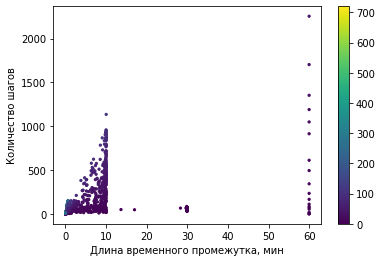

In [18]:
# Посмотрим распределение количества шагов по временным промежуткам и скоростям
plt.scatter(df.segment_min, df.steps, s=5, c=df.speed_steps_in_min)
plt.colorbar()
plt.xlabel('Длина временного промежутка, мин')
plt.ylabel('Количество шагов')

<AxesSubplot: xlabel='speed_steps_in_min', ylabel='Density'>

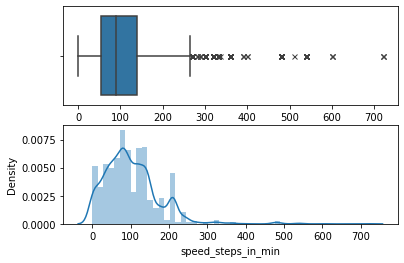

In [19]:
# Посмотрим распределение скорости, видно что медиана в районе 75 шагов в минуту
# Второй пик возможно соответствует бегу, однако данной задачи это не касается
pic, axes = plt.subplots(2,1)
sns.boxplot(df.speed_steps_in_min, flierprops={"marker": "x"}, ax=axes[0])
sns.distplot(df.speed_steps_in_min, ax=axes[1])

In [20]:
# Посмотрим промежутки между записями
df['record_gap']=df['time_start_local'].shift(-1)-df['time_end_local']

In [21]:
# Видим, что есть отрицательные, значит надо упорядочить по времени старта
df.tail()

,time_start_local,time_end_local,steps,segment_min,speed_steps_in_min,record_gap
9815,2022-03-29 10:02:44,2022-03-29 10:09:49,148,7.083333,20.894118,-1 days +22:28:45
9817,2022-03-29 08:38:34,2022-03-29 08:39:18,49,0.733333,66.818182,0 days 05:00:32
9821,2022-03-29 13:39:50,2022-03-29 13:40:45,29,0.916667,31.636364,0 days 08:51:03
9822,2022-03-29 22:31:48,2022-03-29 22:31:50,9,0.033333,270.000000,-1 days +07:18:07
9825,2022-03-29 05:49:57,2022-03-29 05:50:38,37,0.683333,54.146341,NaT


In [22]:
# Отсортируем, обновим индексы и обновим пересчитаем последнюю колонку
df=df.sort_values(by='time_start_local')
df=df.reset_index(drop=True)
df['record_gap']=df['time_start_local'].shift(-1)-df['time_end_local']

In [23]:
# Все еще остались отрицательные проежутки в строках с пересекающимся временем
df[df.record_gap<datetime.timedelta(seconds=0)].head(3)

,time_start_local,time_end_local,steps,segment_min,speed_steps_in_min,record_gap
1745,2022-04-01 23:08:18,2022-04-01 23:08:21,3,0.050000,60.000000,-1 days +23:59:58
1747,2022-04-02 03:41:49,2022-04-02 03:41:51,11,0.033333,330.000000,-1 days +23:59:59
1749,2022-04-02 04:47:52,2022-04-02 04:50:52,40,3.000000,13.333333,-1 days +23:57:01


In [24]:
# Посмотрим насколько пересекаются времена начала и конца
df['start_delta']=(df['time_start_local'].shift(-1)-df['time_start_local']).dt.seconds
df['end_delta']=(df['time_end_local'].shift(-1)-df['time_end_local']).dt.seconds

In [25]:
# По этой выборке можно сделать вывод, что есть два вида записей с отрицательным промежутком между ними
df[df.record_gap<datetime.timedelta(seconds=0)]

,time_start_local,time_end_local,steps,segment_min,speed_steps_in_min,record_gap,start_delta,end_delta
1745,2022-04-01 23:08:18,2022-04-01 23:08:21,3,0.050000,60.000000,-1 days +23:59:58,1.0,1.0
1747,2022-04-02 03:41:49,2022-04-02 03:41:51,11,0.033333,330.000000,-1 days +23:59:59,1.0,1.0
1749,2022-04-02 04:47:52,2022-04-02 04:50:52,40,3.000000,13.333333,-1 days +23:57:01,1.0,1.0
1751,2022-04-02 07:52:10,2022-04-02 07:52:12,4,0.033333,120.000000,-1 days +23:59:59,1.0,1.0
1753,2022-04-02 07:58:58,2022-04-02 08:04:23,91,5.416667,16.800000,-1 days +23:54:36,1.0,1.0
...,...,...,...,...,...,...,...,...
7217,2022-04-19 07:10:34,2022-04-19 07:40:24,48,29.833333,1.608939,-1 days +23:40:36,626.0,85238.0
7219,2022-04-19 07:40:24,2022-04-19 08:10:24,67,30.000000,2.233333,-1 days +23:44:56,896.0,85524.0
7221,2022-04-19 08:10:24,2022-04-19 08:40:24,68,30.000000,2.266667,-1 days +23:31:39,99.0,84702.0
7224,2022-04-19 08:40:24,2022-04-19 09:10:24,42,30.000000,1.400000,-1 days +23:46:53,1013.0,85621.0


In [26]:
# Найдем индексы строк у которых разница в начале и старте со следующей строкой меньше 1 с, а также найдем эти следующие строки
# Видно, что следующая строка дублирует предыдущую с разницами в секунде от начала и старта, при этом скорость на промежутке такая же
first_type_ind=df[(df.record_gap<datetime.timedelta(seconds=0))&(df.start_delta<=1)&(df.end_delta<=1)].index
next_first_type_ind = first_type_ind+1
df[df.index.isin(first_type_ind|next_first_type_ind)]

,time_start_local,time_end_local,steps,segment_min,speed_steps_in_min,record_gap,start_delta,end_delta
1745,2022-04-01 23:08:18,2022-04-01 23:08:21,3,0.050000,60.000000,-1 days +23:59:58,1.0,1.0
1746,2022-04-01 23:08:19,2022-04-01 23:08:22,3,0.050000,60.000000,0 days 04:33:27,16410.0,16409.0
1747,2022-04-02 03:41:49,2022-04-02 03:41:51,11,0.033333,330.000000,-1 days +23:59:59,1.0,1.0
1748,2022-04-02 03:41:50,2022-04-02 03:41:52,11,0.033333,330.000000,0 days 01:06:00,3962.0,4140.0
1749,2022-04-02 04:47:52,2022-04-02 04:50:52,40,3.000000,13.333333,-1 days +23:57:01,1.0,1.0
...,...,...,...,...,...,...,...,...
2050,2022-04-02 21:56:49,2022-04-02 21:57:38,73,0.816667,89.387755,0 days 00:00:32,81.0,91.0
2051,2022-04-02 21:58:10,2022-04-02 21:59:09,111,0.983333,112.881356,-1 days +23:59:02,1.0,1.0
2052,2022-04-02 21:58:11,2022-04-02 21:59:10,111,0.983333,112.881356,-1 days +23:59:59,58.0,15.0
2053,2022-04-02 21:59:09,2022-04-02 21:59:25,13,0.266667,48.750000,-1 days +23:59:45,1.0,1.0


In [27]:
# Убедимся в правильности визуальных наблюдений посмотрев пересечение множества индексов строк, которые дублируют 
# следующую скорость и множество индексов первого типа отрицательных записей
same_steps_index=df[df.index.isin(first_type_ind|next_first_type_ind)&\
                (df.speed_steps_in_min==df.speed_steps_in_min.shift(-1))].index
(set(same_steps_index)^set(first_type_ind))

set()

In [28]:
# Таким образом, можно удалить дубль строки у которых начало и конец периода отличаются на 1 с
df=df[(df.start_delta>1)&(df.end_delta>1)]
df=df.reset_index(drop=True)
df['record_gap']=df['time_start_local'].shift(-1)-df['time_end_local']
df['start_delta']=(df['time_start_local'].shift(-1)-df['time_start_local']).dt.seconds
df['end_delta']=(df['time_end_local'].shift(-1)-df['time_end_local']).dt.seconds

In [29]:
# Остался второй тип записей с отрицательным промежутком, когда вторая запись входит во временной промежуток первой записи
second_type_ind=df[df.record_gap<datetime.timedelta(seconds=0)].index
next_second_type_ind = second_type_ind+1
df[df.index.isin(second_type_ind|next_second_type_ind)]

,time_start_local,time_end_local,steps,segment_min,speed_steps_in_min,record_gap,start_delta,end_delta
2293,2022-04-06 10:26:50,2022-04-06 10:56:50,59,30.000000,1.966667,-1 days +23:34:25,265.0,84894.0
2294,2022-04-06 10:31:15,2022-04-06 10:31:44,33,0.483333,68.275862,0 days 00:00:48,77.0,54.0
2299,2022-04-06 11:26:50,2022-04-06 11:56:40,60,29.833333,2.011173,-1 days +23:47:04,1014.0,85683.0
2300,2022-04-06 11:43:44,2022-04-06 11:44:43,28,0.983333,28.474576,0 days 00:03:15,254.0,211.0
2304,2022-04-06 11:56:40,2022-04-06 12:26:30,59,29.833333,1.977654,-1 days +23:42:10,720.0,85340.0
...,...,...,...,...,...,...,...,...
7062,2022-04-19 08:12:03,2022-04-19 08:12:06,8,0.050000,160.000000,0 days 00:01:55,118.0,123.0
7064,2022-04-19 08:40:24,2022-04-19 09:10:24,42,30.000000,1.400000,-1 days +23:46:53,1013.0,85621.0
7065,2022-04-19 08:57:17,2022-04-19 08:57:25,14,0.133333,105.000000,0 days 00:00:56,64.0,110.0
7068,2022-04-19 09:10:24,2022-04-19 09:40:24,46,30.000000,1.533333,-1 days +23:37:38,458.0,85117.0


In [30]:
# Посмотрим сколько из них входит в другой временной промежуток
# Оставим их в дальнейшем исследовании, т.к. именно на этих участках может быть прогулка
second_type_err_df=df[df.index.isin(second_type_ind|next_second_type_ind)]
internal_time_segment_index=second_type_err_df[(second_type_err_df['time_start_local']<second_type_err_df['time_start_local'].shift(-1))&
                   (second_type_err_df['time_end_local']>second_type_err_df['time_end_local'].shift(-1))].index
# Получим набор индексов, которые не входят в другой временной промежуток, но пересекаются с ним больше чем на 1 с
not_internal_time_segment=(set(internal_time_segment_index)^set(second_type_ind))
print(not_internal_time_segment)

{2335, 2361, 2393, 2412, 2418, 2430, 2480, 2481, 2575, 2593, 2611, 2612, 4765, 4803, 3801, 3810, 2816, 3853, 4878, 6928, 2833, 4888, 4887, 6960, 2877, 5956, 7004, 3933, 3939, 5988, 2919, 3944, 2928, 6014, 6021, 6034, 2976, 6049, 4023, 6089, 4052, 6116}


In [31]:
# Посмотрим сколько данных записывались с промежутком меньше минуты
nearest_actions=df[(df.record_gap<datetime.timedelta(seconds=60))&(df.record_gap>=datetime.timedelta(seconds=0))].index
print(len(nearest_actions))
next_nearest_actions = nearest_actions+1
# Довольно много, необходимо пронаблюдать могут ли эти записи отнсится к одному действию/временному промежутку

5223


In [32]:
# В цикле решим проблему с оставшимися пересекающимися промежутками и в принципе близко записанныи данным
# Введем процент отклонения скорости, по которому мы считаем скорость все той же (например 5%)
appropiate_difference = 15
# Тогда отберем все индексы этих соседних записей
nearest_actions=df[df.record_gap<datetime.timedelta(seconds=60)].index
next_nearest_actions = nearest_actions+1
# Теперь учтем, что записи должны быть не только близки по времени, но и по скорости (в таком случае считаем действие тем же)
appropiate_difference_index = df[(df.index.isin(nearest_actions))&
   (abs(100-df.speed_steps_in_min.shift(-1)*100/df.speed_steps_in_min)<appropiate_difference)].index
next_appropiate_difference_index=appropiate_difference_index+1

new_df=df.copy()

# В цикле проходимся по всему df до тех пор пока близких участков со схожей скоростью не останется
while not appropiate_difference_index.empty:
#     Отберем df для аггрегации из соседних схожих строк
    df_for_aggregation = new_df[new_df.index.isin(appropiate_difference_index|next_appropiate_difference_index)]\
                     [['time_start_local','time_end_local','speed_steps_in_min', 'steps', 'segment_min']]
    
#     Создадим результирующий df, не содержащий строки для агрегации
    result_df=new_df[~new_df.index.isin(appropiate_difference_index|next_appropiate_difference_index)]\
                     [['time_start_local','time_end_local','speed_steps_in_min', 'steps', 'segment_min']]
    
#     Рассчитаем среднее между строками для агрегации
    df_for_aggregation['mean_speed'] = (df_for_aggregation['speed_steps_in_min']+\
                                        df_for_aggregation['speed_steps_in_min'].shift(-1))/2
 
#    Оценим количество шагов по сумме (пусть у них и есть небольшое пересечение)
    df_for_aggregation['sum_steps'] = df_for_aggregation['steps']+df_for_aggregation['steps'].shift(-1)
    
#     Создадим новый df куда занесем все объединенные участки
    new_df=pd.DataFrame()
    new_df['time_start_local'] = df_for_aggregation[df_for_aggregation.index.isin(appropiate_difference_index)]['time_start_local'].values
    new_df['time_end_local'] = df_for_aggregation[df_for_aggregation.index.isin(next_appropiate_difference_index)]['time_end_local'].values
    new_df['speed_steps_in_min'] = df_for_aggregation[df_for_aggregation.index.isin(appropiate_difference_index)]['mean_speed'].values
    new_df['steps'] = df_for_aggregation[df_for_aggregation.index.isin(appropiate_difference_index)]['sum_steps'].values
    
#     Объединим результирующий и полученный df, заново отсортируем и приведем его в порядок
    new_df = pd.concat([result_df, new_df])
    new_df.drop_duplicates(inplace=True)
    new_df=new_df.sort_values(by='time_start_local')
    new_df=new_df.reset_index(drop=True)
#     Заново рассчитаем временные промежутки между записями
    new_df['record_gap']=new_df['time_start_local'].shift(-1)-new_df['time_end_local']
    new_df['segment_min']=(new_df['time_end_local']-new_df['time_start_local']).dt.seconds/60
    
#     Перерасчет индексов    
    nearest_actions=new_df[new_df.record_gap<datetime.timedelta(seconds=60)].index
    next_nearest_actions = nearest_actions+1
    appropiate_difference_index = new_df[(new_df.index.isin(nearest_actions))&
       (abs(100-new_df.speed_steps_in_min.shift(-1)*100/new_df.speed_steps_in_min)<appropiate_difference)].index
    next_appropiate_difference_index=appropiate_difference_index+1

In [33]:
# Получаем df у которого записи со схожими скоростями и временем меньше 60 с между ними объединены в одну
# Заново рассчитаем временной отрезок между началом и концом записи
result_df['segment_min']=(result_df['time_end_local']-result_df['time_start_local']).dt.seconds/60

In [34]:
# Теперь можем отобрать все участки больше 5 минут, представляя что это прогулка
result_df[(result_df['segment_min']>=5)&(result_df['speed_steps_in_min']>=5)].head()

,time_start_local,time_end_local,speed_steps_in_min,steps,segment_min
3,2022-03-19 07:15:33,2022-03-19 07:25:34,14.276206,143.0,10.016667
30,2022-03-19 14:16:15,2022-03-19 14:25:20,19.486239,177.0,9.083333
53,2022-03-19 19:56:30,2022-03-19 20:05:34,15.551471,141.0,9.066667
74,2022-03-20 09:01:42,2022-03-20 09:11:32,8.847458,87.0,9.833333
80,2022-03-20 09:37:04,2022-03-20 09:42:04,11.800000,59.0,5.000000


In [35]:
# Однако скорость тоже имеет значение, т.к. 8 шагов в минуту даже в течение 9 минут это очень странная прогулка
# Поэтому в зависимости от условий можем также добавлять условие скорости, например если мы учитываем даже очень медленные прогулки
result_df[(result_df['segment_min']>=5)&(result_df['speed_steps_in_min']>=15)].head()

,time_start_local,time_end_local,speed_steps_in_min,steps,segment_min
30,2022-03-19 14:16:15,2022-03-19 14:25:20,19.486239,177.0,9.083333
53,2022-03-19 19:56:30,2022-03-19 20:05:34,15.551471,141.0,9.066667
88,2022-03-20 10:02:12,2022-03-20 10:12:07,24.806723,246.0,9.916667
105,2022-03-20 17:45:38,2022-03-20 17:53:30,17.288136,136.0,7.866667
140,2022-03-21 09:12:52,2022-03-21 09:22:19,37.037037,350.0,9.450000


In [36]:
# И например возьмем информацию из интернета, что средняя скорость ходьбы человека - 75 шагов в минуту
# Тогда окончательно будем считать прогулками данный результат
walks=result_df[(result_df['segment_min']>=5)&(result_df['speed_steps_in_min']>=75)]

In [37]:
walks.head()

,time_start_local,time_end_local,speed_steps_in_min,steps,segment_min
173,2022-03-21 14:00:16,2022-03-21 14:06:12,110.160487,3486.0,5.933333
234,2022-03-22 09:06:11,2022-03-22 09:13:47,75.657895,575.0,7.600000
261,2022-03-22 13:12:45,2022-03-22 13:18:28,92.063593,2888.0,5.716667
403,2022-03-23 16:53:28,2022-03-23 17:00:15,76.068796,516.0,6.783333
663,2022-03-26 12:36:48,2022-03-26 12:56:48,87.094075,1742.0,20.000000


In [38]:
# Правильнее будет рассчитать количество шагов заново исходя из скорости и временного промежутка, т.к. могла накопиться ошибка
walks['steps']=round(walks['speed_steps_in_min']*walks['segment_min'])

In [39]:
walks

,time_start_local,time_end_local,speed_steps_in_min,steps,segment_min
173,2022-03-21 14:00:16,2022-03-21 14:06:12,110.160487,654.0,5.933333
234,2022-03-22 09:06:11,2022-03-22 09:13:47,75.657895,575.0,7.600000
261,2022-03-22 13:12:45,2022-03-22 13:18:28,92.063593,526.0,5.716667
403,2022-03-23 16:53:28,2022-03-23 17:00:15,76.068796,516.0,6.783333
663,2022-03-26 12:36:48,2022-03-26 12:56:48,87.094075,1742.0,20.000000
664,2022-03-26 12:56:54,2022-03-26 13:07:10,103.799580,1066.0,10.266667
676,2022-03-26 13:25:19,2022-03-26 13:37:45,102.001958,1268.0,12.433333
688,2022-03-26 14:13:13,2022-03-26 14:19:32,77.889182,492.0,6.316667
1000,2022-03-29 22:15:11,2022-03-29 22:20:23,114.294889,594.0,5.200000
1045,2022-03-30 08:41:53,2022-03-30 08:48:20,98.579545,636.0,6.450000


In [40]:
walks['date']=walks['time_start_local'].dt.strftime("%Y-%m-%d")
walks['start_time']=walks['time_start_local'].dt.strftime("%Y-%m-%d %H:%M:%S")
walks['end_time']=walks['time_end_local'].dt.strftime("%Y-%m-%d %H:%M:%S")

In [41]:
def split_transactions(df):
    for row, df_transactions in df.groupby(['date']):
        yield {row: list(split_line_items(df_transactions)),
        }


def split_line_items(df_transactions):
    for element in df_transactions.itertuples():
        yield {
            'start': element.start_time,
            'end': element.end_time,
            'steps':element.steps
              }

In [42]:
result=split_transactions(walks)

In [43]:
result_json=list(result)

In [45]:
result_json

[{'2022-03-21': [{'start': '2022-03-21 14:00:16',
    'end': '2022-03-21 14:06:12',
    'steps': 654.0}]},
 {'2022-03-22': [{'start': '2022-03-22 09:06:11',
    'end': '2022-03-22 09:13:47',
    'steps': 575.0},
   {'start': '2022-03-22 13:12:45',
    'end': '2022-03-22 13:18:28',
    'steps': 526.0}]},
 {'2022-03-23': [{'start': '2022-03-23 16:53:28',
    'end': '2022-03-23 17:00:15',
    'steps': 516.0}]},
 {'2022-03-26': [{'start': '2022-03-26 12:36:48',
    'end': '2022-03-26 12:56:48',
    'steps': 1742.0},
   {'start': '2022-03-26 12:56:54',
    'end': '2022-03-26 13:07:10',
    'steps': 1066.0},
   {'start': '2022-03-26 13:25:19',
    'end': '2022-03-26 13:37:45',
    'steps': 1268.0},
   {'start': '2022-03-26 14:13:13',
    'end': '2022-03-26 14:19:32',
    'steps': 492.0}]},
 {'2022-03-29': [{'start': '2022-03-29 22:15:11',
    'end': '2022-03-29 22:20:23',
    'steps': 594.0}]},
 {'2022-03-30': [{'start': '2022-03-30 08:41:53',
    'end': '2022-03-30 08:48:20',
    'steps': 6

In [44]:
with open('walkings.json', 'w') as outfile:
    json.dump(result_json, outfile)